In [66]:
import numpy as np
import matplotlib.pyplot as plt

In [67]:
timecalc = 9
tolerance = 1e-7

# load the data
p_ind_read, frame_read, x_read, y_read = np.genfromtxt(
    "./20170202c059_RPE1_CAG_H2B_Halotag_TMR80pM_nonlam_non_starve_ctrl_info.txt",
    unpack=True,
)

# data
data = np.array([p_ind_read, frame_read, x_read, y_read])
data = data.T

In [68]:
# print all shapes
print("data.shape", data.shape)
print("data[0] : ", data[0])

data.shape (11579, 4)
data[0] :  [  1.     0.   148.37 108.4 ]


In [69]:
class Nucleosome:
    def __init__(self, p_ind, data):
        self.p_ind = p_ind
        self.traj = self.get_traj(data)
        self.in_time = self.traj[0, 0]
        self.out_time = self.traj[-1, 0]
        
    
    def get_traj(self, data):
        traj = data[data[:, 0] == self.p_ind]
        traj = traj[:, 1:4]                         # have only [frame, x, y]
        return traj
    

1342
(1342,)


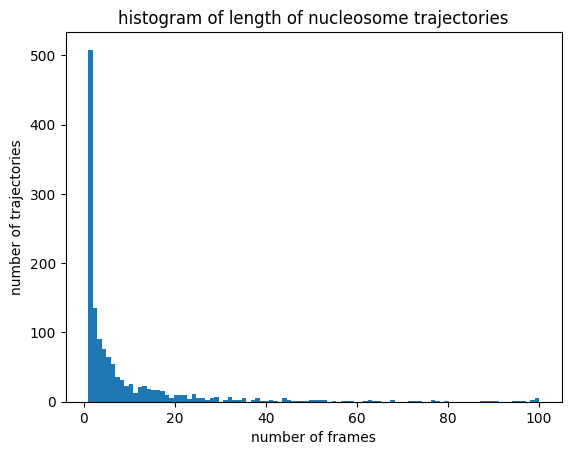

In [70]:
# initialize nucleosomes
nucleosomes = []
for p_ind in np.unique(data[:, 0]):
    nucleosomes.append(Nucleosome(p_ind, data))

hist = []
print(len(nucleosomes))
for nucleosome in nucleosomes:
    if len(nucleosome.traj) > 0:
        hist.append(len(nucleosome.traj))
    # print(len(nucleosome.traj))

hist = np.array(hist)
print(hist.shape)
plt.hist(hist, bins=max(hist))
plt.title("histogram of length of nucleosome trajectories")
plt.xlabel("number of frames")
plt.ylabel("number of trajectories")
plt.show()

In [71]:
# calculate msd for each trajectory which has more than 20 frames
cutoff = 20
msd = []
selected_p_ind = []
for n in nucleosomes:
    if len(n.traj) > cutoff:
        curmsd = np.zeros(cutoff)
        traj = n.traj[:cutoff]
        for i in range(1, cutoff):
            # vectorized
            curmsd[i] = np.sum((traj[i:, 1:3] - traj[0:-i, 1:3])**2) / (cutoff - i)
        msd.append([n.p_ind, curmsd*4225])    # px^2 to nm^2
        selected_p_ind.append(n.p_ind)
# msd = np.array(msd)
print("msd.shape", len(msd))
print("selected_p_ind.shape", len(selected_p_ind))

msd.shape 149
selected_p_ind.shape 149


/tmp/ipykernel_60627/3819409747.py:6: RuntimeWarning: divide by zero encountered in log10
  x = np.log10(np.arange(0, 1.05, 0.05))
/tmp/ipykernel_60627/3819409747.py:9: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(msd[i][1])   # 4225 nm^2 per pixel^2


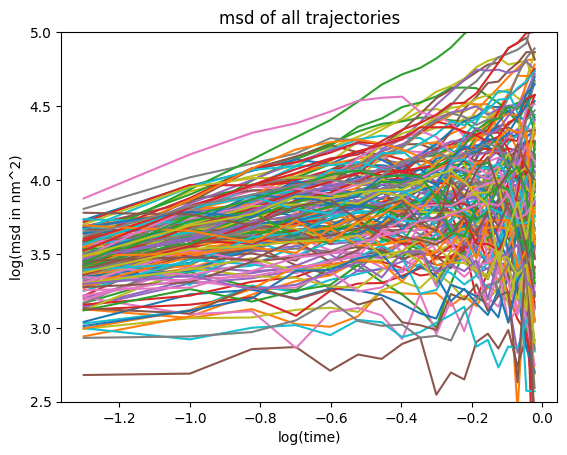

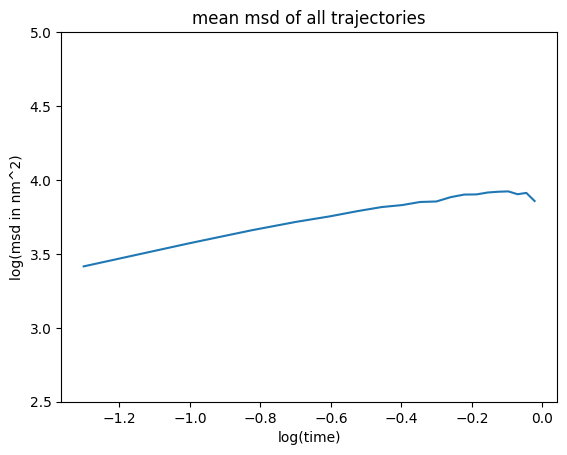

In [72]:
# plot all msd
# y is log of msd
# x is log of time
# np arange 100 frames from 0 s to 5 s
logy = []
x = np.log10(np.arange(0, 1.05, 0.05))
for i in range(len(msd)):
    # if len(msd[i][1]) > 19:
    y = np.log10(msd[i][1])   # 4225 nm^2 per pixel^2
    # y = y[:20]
    logy.append(y)
    # selected_p_ind.append(msd[i][0])
    # plt.plot(msd[i])
    plt.plot(x[:len(y)], y)
plt.title("msd of all trajectories")
plt.xlabel("log(time)")
plt.ylabel("log(msd in nm^2)")
plt.ylim(2.5, 5)
plt.show()

# plot mean msd
logy = np.array(logy)
meany = np.mean(logy, axis=0)
plt.plot(x[:len(meany)], meany)
plt.title("mean msd of all trajectories")
plt.xlabel("log(time)")
plt.ylabel("log(msd in nm^2)")
plt.ylim(2.5, 5)
plt.show()

In [73]:
print(logy.shape)
print(logy)

selected_p_ind = np.array(selected_p_ind)
print(selected_p_ind.shape)
print(selected_p_ind)

(149, 20)
[[      -inf 3.42984771 3.69936178 ... 3.49039712 3.77575367 3.7610548 ]
 [      -inf 3.12492025 3.06656967 ... 2.43896273 3.50051142 3.28038827]
 [      -inf 3.16701826 3.37629654 ... 3.2202561  2.95165013 3.40578376]
 ...
 [      -inf 3.25436266 3.27218839 ... 3.73718614 3.76997389 3.85986287]
 [      -inf 3.61788001 3.82053835 ... 4.15591964 4.40483124 4.47011124]
 [      -inf 3.48425942 3.68999133 ... 3.85195384 3.60219962 3.99387174]]
(149,)
[1.000e+00 2.000e+00 3.000e+00 4.000e+00 5.000e+00 6.000e+00 7.000e+00
 8.000e+00 9.000e+00 1.000e+01 1.100e+01 1.200e+01 1.300e+01 1.400e+01
 1.500e+01 1.600e+01 1.700e+01 1.800e+01 1.900e+01 2.000e+01 2.100e+01
 2.200e+01 2.300e+01 2.400e+01 2.500e+01 2.600e+01 2.700e+01 2.800e+01
 2.900e+01 3.000e+01 3.100e+01 3.200e+01 3.300e+01 3.400e+01 3.500e+01
 3.600e+01 3.700e+01 3.800e+01 3.900e+01 4.000e+01 4.100e+01 1.300e+02
 1.310e+02 1.320e+02 1.410e+02 1.770e+02 1.780e+02 1.790e+02 1.800e+02
 1.810e+02 2.030e+02 2.040e+02 2.190e+02 2

In [74]:
# go over each selected trajectory and calculate alpha using polyfit
new_traj = np.zeros((len(selected_p_ind)*cutoff, 4))   # x,y,t,alpha
new_traj[:, 2] = np.tile(np.arange(0, 1.0, 0.05), len(selected_p_ind))

for i in range(len(selected_p_ind)):
    # get the x and y of the p_ind
    p_ind = int(selected_p_ind[i])
    traj = nucleosomes[p_ind-1].traj
    traj = traj[:cutoff]

    new_traj[i*cutoff:(i+1)*cutoff, 0] = traj[:, 1]
    new_traj[i*cutoff:(i+1)*cutoff, 1] = traj[:, 2]

    xfull = np.log10(np.arange(0, 1.05, 0.05))
    # calculate alpha1
    x1 = xfull[1:5]
    y1 = logy[i][1:5]
    alpha1 = 1
    alpha1, D1 = np.polyfit(x1, y1, 1)

    print("alpha1", alpha1)

    # calculate alpha2
    x2 = xfull[5:20]
    y2 = logy[i][5:20]
    alpha2 = 1
    alpha2, D2 = np.polyfit(x2, y2, 1)
    print("alpha2", alpha2)
    print()

    new_traj[i*cutoff:(i+1)*cutoff, 3] = np.concatenate((np.tile(alpha1, 5), np.tile(alpha2, 15)))

print(new_traj.shape)


alpha1 0.5903008147192964
alpha2 -0.3141847577956822

alpha1 -0.1121866459985301
alpha2 0.14753828547924783

alpha1 0.13615914899274215
alpha2 0.0133263912744619

alpha1 0.8460216064486668
alpha2 -0.9582097579935397

alpha1 0.3227921170238824
alpha2 0.34330999297807485

alpha1 0.34908625097204427
alpha2 0.32830515850889375

alpha1 0.20203408282157861
alpha2 -0.28408647917418334

alpha1 0.5725644691409889
alpha2 0.7849964455452573

alpha1 0.19650908205928538
alpha2 0.34793244740885887

alpha1 0.40216887689665326
alpha2 0.21496005800639403

alpha1 0.9645517115366717
alpha2 -0.0985392347041374

alpha1 0.7255329725158854
alpha2 1.7048973398543208

alpha1 0.6690339093619624
alpha2 0.556792910002578

alpha1 0.5343399943894318
alpha2 -1.524131379318104

alpha1 0.4069336146801624
alpha2 1.3265704053563543

alpha1 0.1793544567255437
alpha2 0.6742261923321518

alpha1 0.884436304156453
alpha2 0.6777707965907652

alpha1 0.3263689359540252
alpha2 0.1424071256472709

alpha1 0.8217194749878051
alpha2

/tmp/ipykernel_60627/466057465.py:14: RuntimeWarning: divide by zero encountered in log10
  xfull = np.log10(np.arange(0, 1.05, 0.05))


In [75]:
# save the new_traj upto 3 decimal places
np.savetxt("new_traj.txt", new_traj, delimiter="\t", fmt="%.3f")